<a href="https://colab.research.google.com/github/soumabkargit/intro-to-machine-learning/blob/master/n_vibe_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.metrics import mean_absolute_error,mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
#Load the Data
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0,device,rssi,Personne,Iteration,Label_pm,lat,lon
0,0,C8:DF:84:32:FA:C6,"[-74, -74, -74, -74, -74, -74, -74, -74, -74, ...",personne1,iteration1,I5,50.844861,4.373333
1,1,C8:DF:84:34:5E:68,"[-86, -86, -86, -86, -86, -86, -86, -87, -87, ...",personne1,iteration1,I5,50.844861,4.373333
2,2,C8:DF:84:28:57:C0,"[-92, -92, -92, -92, -92, -92, -92, -92, -92, ...",personne1,iteration1,I5,50.844861,4.373333
3,3,C8:DF:84:34:1B:03,"[-79, -79, -79, -79, -79, -79, -79, -79, -79, ...",personne1,iteration1,I5,50.844861,4.373333
4,4,C8:DF:84:34:1D:2A,"[-81, -81, -81, -81, -81, -81, -81, -81, -81, ...",personne1,iteration1,I5,50.844861,4.373333


In [27]:
#Data PreProcessing
len(df)
df.isnull().sum()
df = df.dropna()
df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float) #.to_list()

In [28]:
temp_all_rssi_row = ""
array_rssi_row = []
temp_rssi = []
temp_device = []
temp_personne = []
temp_iteration = []
temp_label_pm = []
temp_lat = []
temp_lon = []

for index_df, row_lppi in df.iterrows():
  temp_array_rssi = []
  temp_all_rssi_row = row_lppi['rssi'].lstrip('[')
  temp_all_rssi_row = temp_all_rssi_row.rstrip(']')
  array_rssi_row = temp_all_rssi_row.split(',')

  for rssi in array_rssi_row:
    temp_rssi.append(float(rssi))
    temp_device.append(row_lppi['device'])
    temp_personne.append(row_lppi['Personne'])
    temp_iteration.append(row_lppi['Iteration'])
    temp_label_pm.append(row_lppi['Label_pm'])
    temp_lat.append(row_lppi['lat'])
    temp_lon.append(row_lppi['lon'])

In [29]:
all_data = {'device' : temp_device, 'rssi' : temp_rssi, 'personne' : temp_personne, 'iteration' : temp_iteration, 'label' : temp_label_pm, 'lat' : temp_lat, 'lon' : temp_lon}
df  = pd.DataFrame(data= all_data)

In [ ]:
df.to_csv('data_general.csv')
df.to_excel("data_general.xlsx") 

In [30]:
# Convert Pandas to Numpy for Keras

# Features
X = df['rssi'].values

# Label
y = df[['lat','lon']].values

In [31]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

X_train.shape
X_test.shape
y_train.shape
y_test.shape

print("X_train : ",X_train.shape, " X_test : ",X_test.shape, " y_train : ",y_train.shape, " y_test : ",y_test.shape)

X_train :  (564505,)  X_test :  (241931,)  y_train :  (564505, 2)  y_test :  (241931, 2)


In [32]:
#Creating a Model
model = Sequential()

model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(4,activation='relu'))

# Final output node for prediction
model.add(Dense(1))

model.compile(optimizer='rmsprop',loss='mse')

In [33]:
#Training
#early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
model.fit(x=X_train, 
          y=y_train, 
          epochs=5,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/5
17641/17641 [==============================] - 21s 1ms/step - loss: 546.9775 - val_loss: 540.0488
Epoch 2/5
17641/17641 [==============================] - 21s 1ms/step - loss: 540.2626 - val_loss: 539.9590
Epoch 3/5
17641/17641 [==============================] - 21s 1ms/step - loss: 540.0034 - val_loss: 540.8401
Epoch 4/5
17641/17641 [==============================] - 21s 1ms/step - loss: 539.9753 - val_loss: 539.9384
Epoch 5/5
17641/17641 [==============================] - 21s 1ms/step - loss: 539.9744 - val_loss: 539.9385


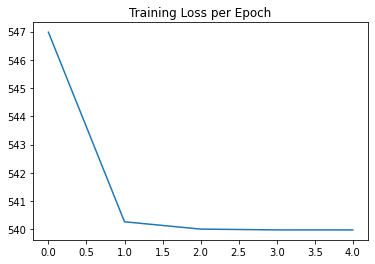

In [34]:
#Evaluation
model.history.history
loss = model.history.history['loss']
sns.lineplot(x=range(len(loss)),y=loss)
plt.title("Training Loss per Epoch");

In [35]:
model.metrics_names
training_score = model.evaluate(X_train,y_train,verbose=0)

In [36]:
test_score = model.evaluate(X_test,y_test,verbose=0)

In [38]:
print('training_score :', training_score, 'test_score :', test_score)

training_score : 539.9736328125 test_score : 539.9385375976562


In [39]:
test_predictions = model.predict(X_test)
test_predictions

array([[27.591536],
       [27.59212 ],
       [27.59186 ],
       ...,
       [27.58002 ],
       [27.59186 ],
       [27.591927]], dtype=float32)

In [ ]:
#Compare final evaluation (MSE) on training set and test set.
model.metrics_names
training_score = model.evaluate(X_train,y_train,verbose=0)
test_score = model.evaluate(X_test,y_test,verbose=0)
training_score
test_score
test_predictions = model.predict(X_test)
test_predictions
pred_df = pd.DataFrame(y_test,columns=['Test Y'])
pred_df
test_predictions = pd.Series(test_predictions.reshape(300,))
test_predictions
pred_df = pd.concat([pred_df,test_predictions],axis=1)
pred_df.columns = ['Test Y','Model Predictions']
pred_df
sns.scatterplot(x='Test Y',y='Model Predictions',data=pred_df)
pred_df['Error'] = pred_df['Test Y'] - pred_df['Model Predictions']
sns.distplot(pred_df['Error'],bins=50)
mean_absolute_error(pred_df['Test Y'],pred_df['Model Predictions'])
mean_squared_error(pred_df['Test Y'],pred_df['Model Predictions'])

In [ ]:
# Essentially the same thing, difference just due to precision
test_score

#RMSE
test_score**0.5

#Predicting on brand new data
# [[Feature1, Feature2]]
new_gem = [[998,1000]]
# Don't forget to scale!
scaler.transform(new_gem)
new_gem = scaler.transform(new_gem)
model.predict(new_gem)
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
later_model = load_model('my_model.h5')
later_model.predict(new_gem)